# Cross-Validation

### Theory

Models are often trained on limited datasets for various reasons. When the amount of data is small, there tends to be greater variance in the accuracy of different instances of the same model. This is because smaller datasets may not capture the full diversity of the underlying data distribution, making the model more susceptible to overfitting noise or specific patterns. As a result, model performance becomes more sensitive to statistical fluctuations, leading to inconsistent outcomes. This variability makes it more challenging to reliably quantify the model’s true performance. Let us demonstrate this observation with a random forested classifier trained on the sci-kit learn's breast cancer dataset. With only $569$ data points, a typical train-test split of $4:1$ creates noticable variation in the accuracy between instances of the same model. Only $114$ examples compose the testing dataset. We train $N=100$ random forest classifiers and plot their accuracy on the testing dataset,

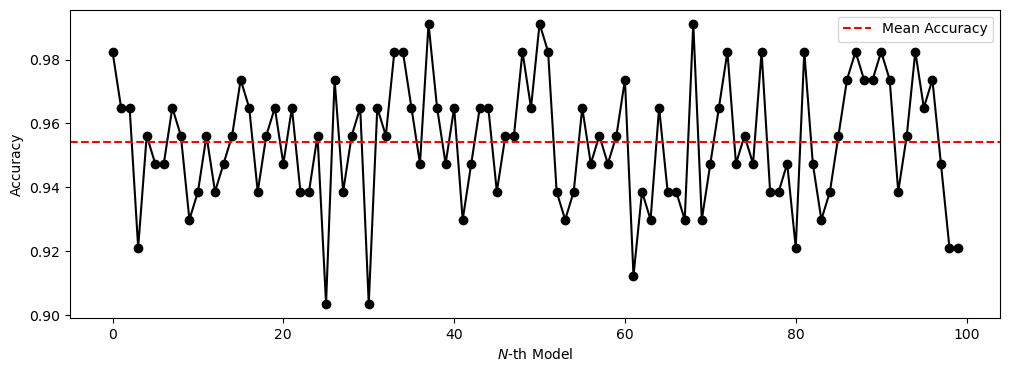

In [1]:
# Imports,
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading data,
dataset = load_breast_cancer()
X, y = dataset["data"], dataset["target"]

# Creating N models,
N = 100
accuracy_list = []
for i in range(N):

    # Creating data split,
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

    # Creating model,
    clf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)

    # Fitting model,
    clf.fit(X_train, y_train)

    # Computing accuracy,
    accuracy = clf.score(X_test, y_test)
    accuracy_list.append(accuracy)

# Plotting,
plt.figure(figsize=(12, 4))
plt.plot(accuracy_list, color="black", marker="o")
plt.axhline(y=np.mean(accuracy_list), color="r", linestyle="--", label="Mean Accuracy")
plt.xlabel("$N$-th Model")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We see the accuracy of the model varies between 90% and 99$ with the "true" accuracy being around 95-96%. To address this issue, **K-fold cross-validation** is a commonly used in machine-learning workflows. It is a standard technique that aims to mitigate statistical randomness encountered when assessing the accuracy of models trained on limited datasets. The idea is that the full dataset $X$ is split into $k$-number of equally sized partitions called folds. Each fold contains data points that have been randomly selected and no two folds can have the same datapoint. We also have $k$ number of iterations and during each cycle a single fold is assigned as the testing dataset while all other folds are combined to create the training dataset. Note that the choosen fold must not have been selected before. At the end of this process, all folds have been used as the testing dataset exactly once. The puesdocode for this algorithm can be written as, 

**Given:**

- A dataset $X = \{X_1, X_2, \dots, X_N\}$ with $N$ number of data points.
- An integer $k \in \mathbb{N}$, such that $2 \leq k \leq N$ ($k=5$ and $k=10$ are common choices).

---
**Algorithm:**  
1. **Shuffle** the dataset:  
   $X \leftarrow \text{RandomShuffle}(X)$

2. **Partition** $X$ into $k$ disjoint subsets (folds):  
   $X = F_1 \cup F_2 \cup \dots \cup F_k$ such that $F_i \cap F_j = \emptyset$ for $i \ne j$.

3. **Initialise** an empty list of evaluation scores:  
   $S \leftarrow \emptyset$

4. **For** each $i = 1$ to $k$:

   (a). Define the test set: $X_{\text{test}} \leftarrow F_i$

   (b). Define the training set: $X_{\text{train}} \leftarrow \bigcup_{\substack{j = 1 \\ j \ne i}}^k F_j$

   (c). Train a model $\mathcal{M}_i$ on $X_{\text{train}}$.

   (d). Evaluate $\mathcal{M}_i$ on $X_{\text{test}}$ to obtain a score $s_i$:  
      $s_i \leftarrow \text{Score}(\mathcal{M}_i, X_{\text{test}})$

   (e). Append $s_i$ to the scores list:  
      $S \leftarrow S \cup \{s_i\}$

5. **Return** the aggregated metric (e.g., mean):  
   $S_{mean} = \frac{1}{k} \sum_{i=1}^k s_i$




Now we implement this puesdocode in Python,

In [10]:
# Hyperparameters,
k=5
N = X.shape[0]
X_idxs = np.arange(start=0, stop=N, step=1)

# Randomly shuffle datapoints,
np.random.shuffle(X_idxs)

# Creating folds,
folds_idxs = np.array_split(X_idxs, k) # <-- List of arrays

# Training loop,
model_accuracies = []
for i in range(k):

    # Creating classifer model,
    clf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)

    # Extracting the indices of the fold,
    fold_idxs = folds_idxs[i]

    # Extracting the complimentary indices to the fold,
    fold_compliment_idxs = np.array([], dtype=int)
    for j in range(k):
        if j != i:
            fold_compliment_idxs = np.concatenate((fold_compliment_idxs, folds_idxs[j]), axis=0)

    # Creating dataspilt,
    X_train, y_train = X[fold_compliment_idxs], y[fold_compliment_idxs]
    X_test, y_test = X[fold_idxs], y[fold_idxs]

    # Fitting the model,
    clf.fit(X_train, y_train)

    # Scoring the model,
    accuracy = clf.score(X_test, y_test)
    model_accuracies.append(accuracy)

# Printing mean accuracy,
print(f"Accuracy: {np.mean(model_accuracies)}")

Accuracy: 0.9525694767893185


When running the code block numerous times, we see that model accuracy falls in a much smaller range of 94-96%. Let us package our code in a class to allow for more advanced analysis,

In [12]:
class CrossValidation():
    """Class for the k-fold cross-validation algorithm."""

    def __init__(self, k, model_fn):
        """Constuctor method. This method assigns the class variables."""

        # Assigning hyperparametes as class variables,
        self.k = k

        # Storing model class,
        self.model_fn = model_fn

    def evaluate(self, X, y):
        """This method perfoms cross-validation on the dataset X."""

        # Assigning class variables,
        self.X, self.y = X, y

        # Generating indices,
        N = X.shape[0]
        X_idxs = np.arange(start=0, stop=N, step=1)

        # Randomly shuffle datapoints,
        np.random.shuffle(X_idxs)

        # Creating folds,
        folds_idxs = np.array_split(X_idxs, self.k) # <-- List of arrays

        # Evaluation loop,
        model_accuracies = []
        for i in range(k):

            # Creating model instance,
            model = self.model_fn()

            # Extracting the indices of the fold,
            fold_idxs = folds_idxs[i]

            # Extracting the complimentary indices to the fold,
            fold_compliment_idxs= np.concatenate([folds_idxs[j] for j in range(self.k) if j != i])

            # Creating data split,
            X_train, y_train = X[fold_compliment_idxs], y[fold_compliment_idxs]
            X_test, y_test = X[fold_idxs], y[fold_idxs]

            # Fitting the model,
            model.fit(X_train, y_train)

            # Scoring the model,
            accuracy = model.score(X_test, y_test)
            model_accuracies.append(accuracy)
        
        # Returning the mean model accuracy,
        return np.mean(model_accuracies)

Hopefully, my _CrossValidation_ class should work for any model as long as it has a _fit()_ and _score()_ method (including my "from scratch" models). The boiler-plate code for performing cross-validation is then,

In [18]:
# Creating model,
clf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)

# Performing cross-validation on the model,
CV = CrossValidation(k=5, model_fn=lambda: clf)
CV.evaluate(X, y)

0.9543083372147182

Let us run the same experiment we did at the beginning of the notebook and compare the variance,

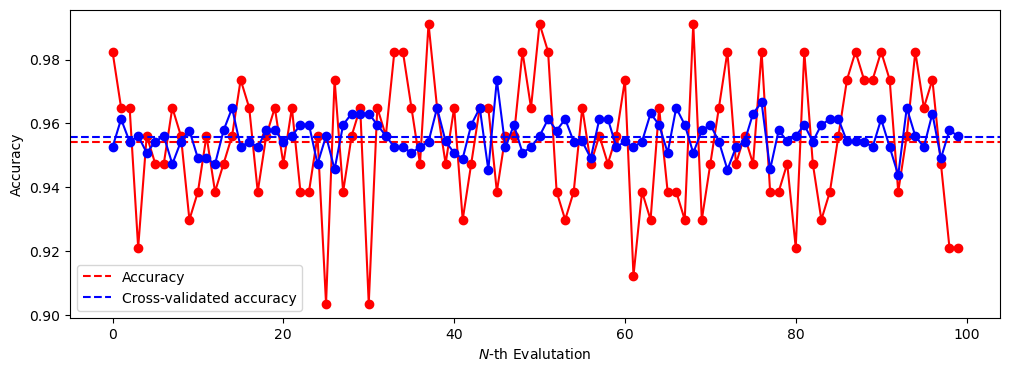

In [19]:
# Creating model,
clf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)

# Running cross-validation,
N = 100
cv_accuracy_list = []
for i in range(N):
    CV = CrossValidation(k=5, model_fn=lambda: clf)
    accuracy = CV.evaluate(X, y)
    cv_accuracy_list.append(accuracy)

# Plotting,
plt.figure(figsize=(12, 4))
plt.plot(accuracy_list, color="red", marker="o")
plt.axhline(y=np.mean(accuracy_list), color="red", linestyle="--", label="Accuracy")
plt.plot(cv_accuracy_list, color="blue", marker="o")
plt.axhline(y=np.mean(cv_accuracy_list), color="blue", linestyle="--", label="Cross-validated accuracy")
plt.xlabel("$N$-th Evalutation")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It is clear that cross-validation reduces the variance associated with the scored accuracy of the model. We see that the model accuracy determined from cross-validation will statisically be much closer than the true model accuracy compared to that which was calculated from only a single model instance.

## References

https://machinelearningmastery.com/k-fold-cross-validation/

https://www.youtube.com/watch?v=wjILv3-UGM8
